# Model-2 Testing 


The aim of this notebook is to test Model-2 against the original test datasets chosen to evaluate this model, namely; Gab, Reddit, Twitter. This notebook does provide test results to Gab_reddit_test dataset to differentiate performances. Here, the model class is defined under the monomer of baseRoberta. The class is identitical to that of the Model-2 fine-tuning notebook. The saved model is loaded into the file using torch.load from the file path. This notebook finally demonstrates the comparison ROC-AUC curves and a confusion matrix for the Gab_reddit dataset. 

## Part 1: Data Preparation
- Loading data to fine-tune using Huggingface's load_dataset module
- Loading Gab, Reddit and Twitter datasets using load_dataset module

## Part 2: Load tokenizer
- Load the tokenizer for the chosen model
- Tokenize the text in 'Content' of the dataset
- Use data collator from Huggingface to batch texts of similar lengths

## Part 3: Model class definition
- Load the tokenizer for the chosen model
- Definition of the model with the pre-trained layer, Bidirectional LSTM and CNN layer to generate the necessary classified output
- Loading saved model into the cuda device

## Part 3: Gab test
- Preparation of the dataset to tensor
- Tokenize the text in 'Content' of the dataset
- Use data collator from Huggingface to batch texts of similar lengths
- Creation of dataloaders for test with a maximum length of 75 (i.e,) the token length in the dataset
- Setting of the metrics required to evaluate model performance
- Testing the model on the dataset
- Evaluation of the metrics by optaining 'Confusion matrix'
- Subset the misclassified data
- Creating word cloud to visualise the words appearing in misclassified data
- Plotting the ROC-AUC

## Part 4: Reddit Test
- Preparation of the dataset to tensor
- Tokenize the text in 'Content' of the dataset
- Use data collator from Huggingface to batch texts of similar lengths
- Creation of dataloaders for test with a maximum length of 30 (i.e,) the token length in the dataset
- Setting of the metrics required to evaluate model performance
- Testing the model on the dataset
- Evaluation of the metrics by optaining 'Confusion matrix'
- Subset the misclassified data
- Creating word cloud to visualise the words appearing in misclassified data
- Plotting the ROC-AUC

## Part 5: Twitter Test

- Preparation of the dataset to tensor
- Tokenize the text in 'Content' of the dataset
- Use data collator from Huggingface to batch texts of similar lengths
- Creation of dataloaders for test with a maximum length of 120 (i.e,) the token length in the dataset
- Setting of the metrics required to evaluate model performance
- Testing the model on the dataset
- Evaluation of the metrics by optaining 'Confusion matrix'
- Plotting the ROC-AUC

## Part 6: Comparison

- Plotting of a comparison ROC-AUC for Gab, Reddit and Twitter

## Part 7: Gab_reddit Test

- Preparation of the dataset to tensor
- Tokenize the text in 'Content' of the dataset
- Use data collator from Huggingface to batch texts of similar lengths
- Creation of dataloaders for test with a maximum length of 100 (i.e,) the token length in the dataset
- Setting of the metrics required to evaluate model performance
- Testing the model on the dataset
- Evaluation of the metrics by optaining 'Confusion matrix'


## Data preparation

In [1]:
#import necessary modules 
from datasets import load_dataset,Dataset,DatasetDict
from transformers import DataCollatorWithPadding,AutoModelForSequenceClassification, Trainer, TrainingArguments,AutoTokenizer,AutoModel,AutoConfig
from transformers.modeling_outputs import TokenClassifierOutput
import torch
import torch.nn as nn
import pandas as pd

In [2]:
#upload necessary datasets
gab = load_dataset('csv',data_files='gab_again2.csv') 
reddit = load_dataset('csv',data_files='cleaned_reddit4.csv')
twitter = load_dataset('csv',data_files='cleaned_tweets01.csv')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /home/ec22022/.cache/huggingface/datasets/csv/default-298825c181b1e235/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /home/ec22022/.cache/huggingface/datasets/csv/default-e8c4a48c0977570c/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:01<?, ?it/s]

Found cached dataset csv (/home/ec22022/.cache/huggingface/datasets/csv/default-b0e14e99ae8be3bb/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d)


  0%|          | 0/1 [00:00<?, ?it/s]

## Model definition 

In [2]:
#downloading the model's checkpoint from huggingface 
checkpoint = "cardiffnlp/twitter-roberta-base-hate-latest"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
tokenizer.model_max_len=512

In [3]:
#define the class 
class baseRoberta(nn.Module):
  def __init__(self,checkpoint,num_labels):
    super(baseRoberta,self).__init__()
    self.num_labels = num_labels

    #Load Model with given checkpoint and extract its body
    self.model = model = AutoModel.from_pretrained(checkpoint,config=AutoConfig.from_pretrained(checkpoint, output_attentions=True,output_hidden_states=True))
    self.dropout = nn.Dropout(0.1)
    self.classifier = nn.Linear(768,num_labels) # load and initialize weights

  def forward(self, input_ids=None, attention_mask=None,Label=None):
    #Extract outputs from the body
    outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)

    #Add custom layers
    sequence_output = self.dropout(outputs[0]) #outputs[0]=last hidden state

    logits = self.classifier(sequence_output[:,0,:].view(-1,768)) # calculate losses

    loss = None
    if Label is not None:
      loss_fct = nn.CrossEntropyLoss()
      loss = loss_fct(logits.view(-1, self.num_labels), Label.view(-1))

    return TokenClassifierOutput(loss=loss, logits=logits, hidden_states=outputs.hidden_states,attentions=outputs.attentions)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=baseRoberta(checkpoint=checkpoint,num_labels=2).to(device)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-hate-latest were not used when initializing RobertaModel: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-hate-latest and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predi

In [5]:
model.load_state_dict(torch.load('model_weights.pt'))

<All keys matched successfully>

## Gab Test

In [7]:
import matplotlib.pyplot as plt 

In [8]:
df_g = pd.read_csv('gab_again2.csv')


In [9]:
df_g.dropna(inplace=True)
df_g['Content'] = df_g['Content'].astype('str')
df_g.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3007 entries, 0 to 3006
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  3007 non-null   int64 
 1   Content     3007 non-null   object
 2   Label       3007 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 70.6+ KB


In [10]:
df_g['Content'] = df_g['Content'].astype(str)


In [11]:
df_g.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3007 entries, 0 to 3006
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  3007 non-null   int64 
 1   Content     3007 non-null   object
 2   Label       3007 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 70.6+ KB


<Axes: >

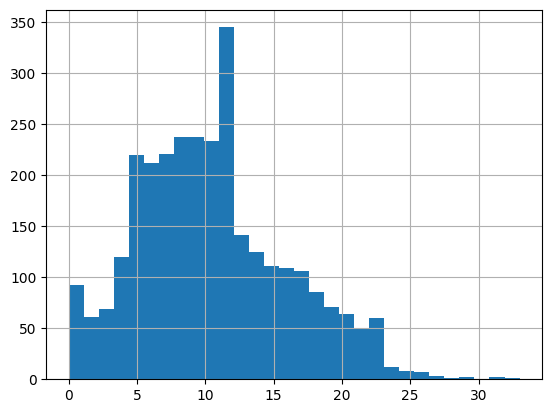

In [16]:
seq_len = [len(i.split()) for i in df_g['Content']]

pd.Series(seq_len).hist(bins = 30)
     

In [14]:
#setting format 
gab.set_format('pandas')
gab=gab['train'][:]
gab=Dataset.from_pandas(gab)
gab = DatasetDict({'test':gab})
gab

DatasetDict({
    test: Dataset({
        features: ['Unnamed: 0', 'Content', 'Label'],
        num_rows: 3007
    })
})

In [15]:
gab = gab.remove_columns('Unnamed: 0')
gab

DatasetDict({
    test: Dataset({
        features: ['Content', 'Label'],
        num_rows: 3007
    })
})

In [7]:
def tokenize(batch):
    return tokenizer(batch["Content"], truncation=True,max_length=max_length)



In [6]:
def delete_null_rows(dataset_dict):
    for key, dataset in dataset_dict.items():
        null_indices = [idx for idx, row in enumerate(dataset) if any(value is None for value in row.values())]
        dataset = dataset.select([i for i in range(len(dataset)) if i not in null_indices])
        dataset_dict[key] = dataset
    return dataset_dict

delete_null_rows(gab)#delete missing data rows

In [19]:
max_length = 75
tokenized_gab = gab.map(tokenize, batched=True) #map the tokenize function to the texts in Content
tokenized_gab

Map:   0%|          | 0/3007 [00:00<?, ? examples/s]

DatasetDict({
    test: Dataset({
        features: ['Content', 'Label', 'input_ids', 'attention_mask'],
        num_rows: 3007
    })
})

In [8]:
from torch.utils.data import DataLoader
data_collator = DataCollatorWithPadding(tokenizer=tokenizer) #instantiate data collator with tokenizer as parameter

In [21]:
tokenized_gab.set_format("torch",columns=["input_ids", "attention_mask", "Label"])
gab_dataloader = DataLoader(
    tokenized_gab["test"], batch_size=16, collate_fn=data_collator
) #load data into data loader for test loop

In [9]:
from datasets import load_metric
metric1 = load_metric("f1")
metric2 = load_metric("accuracy")
metric3 = load_metric("precision")

/tmp/ipykernel_1492578/256772457.py:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric1 = load_metric("f1")


In [10]:
from tqdm.auto import tqdm


In [24]:
model.eval() #to evaluate the model for th given dataset


progress_bar_eval = tqdm(range(1 * len(gab_dataloader)))


for batch in gab_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions_gab = torch.argmax(logits, dim=-1)
    metric1.add_batch(predictions=predictions_gab, references=batch["Label"])
    metric2.add_batch(predictions=predictions_gab, references=batch["Label"])
    metric3.add_batch(predictions=predictions_gab, references=batch["Label"])
    progress_bar_eval.update(1)

print(metric1.compute())
print(metric2.compute())
print(metric3.compute())

  0%|          | 0/188 [00:00<?, ?it/s]

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'f1': 0.2803180914512922}
{'accuracy': 0.759228466910542}
{'precision': 0.17825537294563842}


In [17]:
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import confusion_matrix


In [28]:
gab_predictions=[]
gab_true_labels=[]

model.eval() #to print confusion matrix 
with torch.no_grad():
    for batch in gab_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)

        logits = outputs.logits
        predictions_g = torch.argmax(logits, dim=-1)
        true_labels = batch["Label"]

        gab_predictions.extend(predictions_g.cpu().numpy())
        gab_true_labels.extend(true_labels.cpu().numpy())
        #progress_bar_eval = tqdm(range(1 * len(twitter_dataloader)))


# Convert the lists to NumPy arrays
gab_predictions = np.array(gab_predictions)
gab_true_labels = np.array(gab_true_labels)

In [29]:
confusion_matrix_result = confusion_matrix(gab_true_labels, gab_predictions)

In [30]:
#print confusion matrix 
confusion_matrix_df = pd.DataFrame(confusion_matrix_result, index=["True no_hate", "True hate"], columns=["Pred no_hate", "Pred hate"])
print(confusion_matrix_df)

              Pred no_hate  Pred hate
True no_hate          2142        650
True hate               74        141


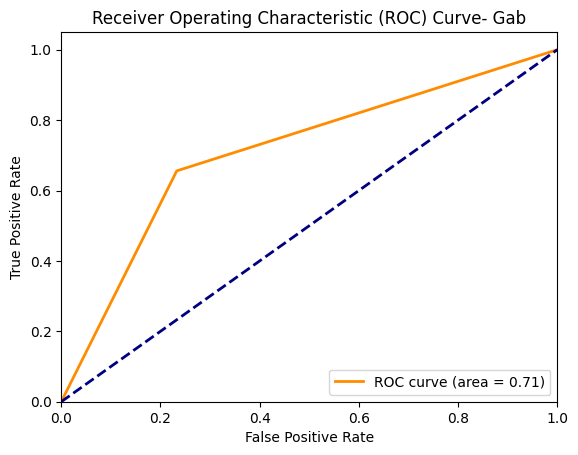

In [31]:
fpr_g, tpr_g, thresholds = roc_curve(gab_true_labels, gab_predictions)
roc_auc_gab = roc_auc_score(gab_true_labels, gab_predictions)

# Plot the ROC curve
plt.figure()
plt.plot(fpr_g, tpr_g, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_gab)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve- Gab')
plt.legend(loc='lower right')
plt.show()

## Reddit test  

Repeat the steps taken in Gab 

In [32]:
reddit.set_format('pandas')
reddit=reddit['train'][:]
reddit=Dataset.from_pandas(reddit)
reddit = DatasetDict({'test':reddit})
reddit

DatasetDict({
    test: Dataset({
        features: ['Unnamed: 0', 'Content', 'Label'],
        num_rows: 2117
    })
})

In [33]:
reddit = reddit.remove_columns('Unnamed: 0')
delete_null_rows(reddit)

DatasetDict({
    test: Dataset({
        features: ['Content', 'Label'],
        num_rows: 2117
    })
})

In [37]:
max_length = 30 #maximum length of reddit sequences

tokenized_reddit = reddit.map(tokenize, batched=True)
tokenized_reddit

Map:   0%|          | 0/2117 [00:00<?, ? examples/s]

DatasetDict({
    test: Dataset({
        features: ['Content', 'Label', 'input_ids', 'attention_mask'],
        num_rows: 2117
    })
})

In [38]:
tokenized_reddit.set_format("torch",columns=["input_ids", "attention_mask", "Label"])
reddit_dataloader = DataLoader(
    tokenized_reddit["test"], batch_size=16, collate_fn=data_collator
)

In [39]:
model.eval()


progress_bar_eval = tqdm(range(1 * len(reddit_dataloader)))


for batch in reddit_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions_reddit = torch.argmax(logits, dim=-1)
    metric1.add_batch(predictions=predictions_reddit, references=batch["Label"])
    metric2.add_batch(predictions=predictions_reddit, references=batch["Label"])
    metric3.add_batch(predictions=predictions_reddit, references=batch["Label"])
    progress_bar_eval.update(1)

print(metric1.compute())
print(metric2.compute())
print(metric3.compute())

  0%|          | 0/133 [00:00<?, ?it/s]

{'f1': 0.36188811188811193}
{'accuracy': 0.6551724137931034}
{'precision': 0.29784172661870506}


In [40]:
reddit_predictions=[]
reddit_true_labels=[]

model.eval()
with torch.no_grad():
    for batch in reddit_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)

        logits = outputs.logits
        predictions_reddit = torch.argmax(logits, dim=-1)
        true_labels = batch["Label"]

        reddit_predictions.extend(predictions_reddit.cpu().numpy())
        reddit_true_labels.extend(true_labels.cpu().numpy())
        #progress_bar_eval = tqdm(range(1 * len(twitter_dataloader)))


# Convert the lists to NumPy arrays
reddit_predictions = np.array(reddit_predictions)
reddit_true_labels = np.array(reddit_true_labels)

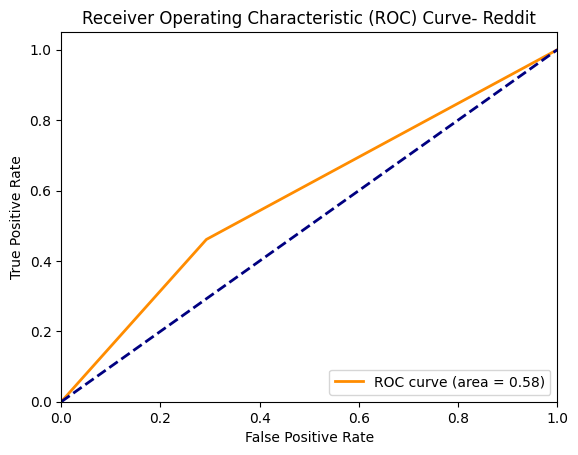

In [41]:
fpr3, tpr3, thresholds = roc_curve(reddit_true_labels, reddit_predictions)
roc_auc_reddit = roc_auc_score(reddit_true_labels, reddit_predictions)

# Plot the ROC curve
plt.figure()
plt.plot(fpr3, tpr3, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_reddit)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve- Reddit')
plt.legend(loc='lower right')
plt.show()

## Twitter test

In [42]:
twitter.set_format('pandas')
twitter=twitter['train'][:]
twitter=Dataset.from_pandas(twitter)
twitter = DatasetDict({'test':twitter})
twitter = twitter.remove_columns('Unnamed: 0')
delete_null_rows(twitter)

DatasetDict({
    test: Dataset({
        features: ['Content', 'Label'],
        num_rows: 1118
    })
})

In [43]:
max_length =120
tokenized_twitter = twitter.map(tokenize, batched=True)


Map:   0%|          | 0/1118 [00:00<?, ? examples/s]

In [44]:
tokenized_twitter.set_format("torch",columns=["input_ids", "attention_mask", "Label"])
twitter_dataloader = DataLoader(
    tokenized_twitter["test"], batch_size=16, collate_fn=data_collator
)

In [45]:
model.eval()


progress_bar_eval = tqdm(range(1 * len(twitter_dataloader)))


for batch in twitter_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions_twitter = torch.argmax(logits, dim=-1)
    metric1.add_batch(predictions=predictions_twitter, references=batch["Label"])
    metric2.add_batch(predictions=predictions_twitter, references=batch["Label"])
    metric3.add_batch(predictions=predictions_twitter, references=batch["Label"])
    progress_bar_eval.update(1)

print(metric1.compute())
print(metric2.compute())
print(metric3.compute())

  0%|          | 0/70 [00:00<?, ?it/s]

{'f1': 0.746317512274959}
{'accuracy': 0.8613595706618963}
{'precision': 0.7015384615384616}


In [46]:
all_predictions=[]
all_true_labels=[]

model.eval()
with torch.no_grad():
    for batch in twitter_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)

        logits = outputs.logits
        predictions_twitter = torch.argmax(logits, dim=-1)
        true_labels = batch["Label"]

        all_predictions.extend(predictions_twitter.cpu().numpy())
        all_true_labels.extend(true_labels.cpu().numpy())
        #progress_bar_eval = tqdm(range(1 * len(twitter_dataloader)))


# Convert the lists to NumPy arrays
all_predictions = np.array(all_predictions)
all_true_labels = np.array(all_true_labels)

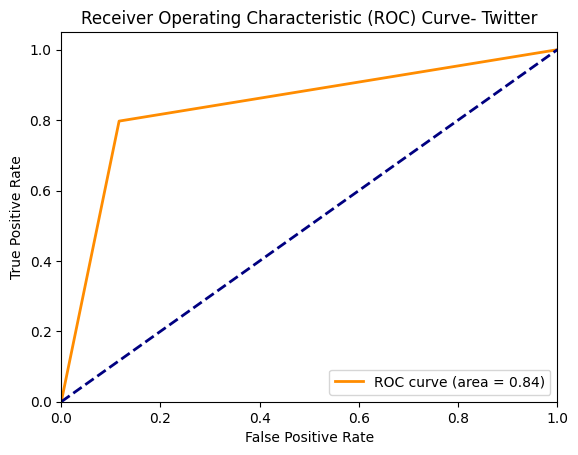

In [47]:
fpr1, tpr1, thresholds = roc_curve(all_true_labels, all_predictions)
roc_auc = roc_auc_score(all_true_labels, all_predictions)

# Plot the ROC curve
plt.figure()
plt.plot(fpr1, tpr1, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve- Twitter')
plt.legend(loc='lower right')
plt.show()

## Test comparison Gab, Reddit and Twitter

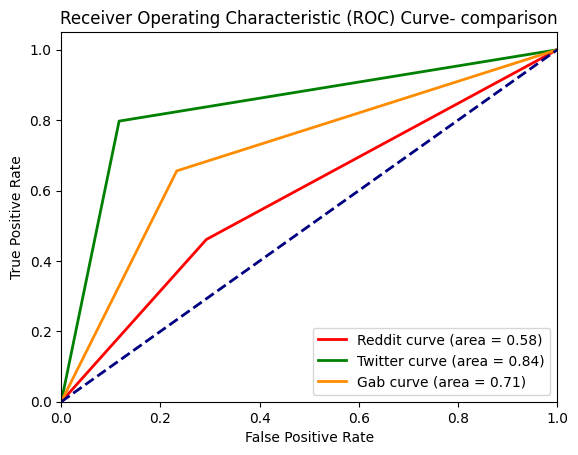

In [49]:
plt.figure()
plt.plot(fpr3, tpr3, color='red', lw=2, label='Reddit curve (area = %0.2f)' % roc_auc_reddit)
plt.plot(fpr1, tpr1, color='green', lw=2, label='Twitter curve (area = %0.2f)' % roc_auc)
plt.plot(fpr_g, tpr_g, color='darkorange', lw=2, label='Gab curve (area = %0.2f)' % roc_auc_gab)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve- comparison')
plt.legend(loc='lower right')
plt.show()

## Gab + Reddit  
Gab_reddit_test 

In [12]:
gr = load_dataset('csv',data_files = 'gabb_reddit_test.csv')
gr

Found cached dataset csv (/home/ec22022/.cache/huggingface/datasets/csv/default-b12122af41594760/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d)


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['Content', 'Label'],
        num_rows: 8910
    })
})

In [13]:
delete_null_rows(gr)

DatasetDict({
    train: Dataset({
        features: ['Content', 'Label'],
        num_rows: 8822
    })
})

In [14]:
gr.set_format('pandas')
gabb_reddit=gr['train'][:]
gabb_reddit=Dataset.from_pandas(gabb_reddit)

In [15]:
gabb_reddit = DatasetDict({
    'test': gabb_reddit
    })

In [16]:
max_length = 100
tokens_gr = gabb_reddit.map(tokenize, batched = True)

Map:   0%|          | 0/8822 [00:00<?, ? examples/s]

In [18]:
from torch.utils.data import DataLoader
tokens_gr.set_format("torch",columns=["input_ids", "attention_mask", "Label"])

gr_dataloader = DataLoader(
    tokens_gr["test"], batch_size=16, collate_fn=data_collator
)

In [19]:


model.eval()


progress_bar_eval = tqdm(range(1 * len(gr_dataloader)))


for batch in gr_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions_gr= torch.argmax(logits, dim=-1)
    metric1.add_batch(predictions=predictions_gr, references=batch["Label"])
    metric2.add_batch(predictions=predictions_gr, references=batch["Label"])
    metric3.add_batch(predictions=predictions_gr, references=batch["Label"])
    progress_bar_eval.update(1)

print(metric1.compute())
print(metric2.compute())
print(metric3.compute())

  0%|          | 0/552 [00:00<?, ?it/s]

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'f1': 0.785550165943324}
{'accuracy': 0.8095669916118794}
{'precision': 0.7554628038301007}
